**Struc2vec**

Struc2vec is an algorithm only considering the **structural identity** of each node in the graph.

It firstly find the **k-hop** neighbors for each node, which is reasonable, because these neighbors could form k rings to indicate the structure of the subgraph around the center node. In this case, if we want to check whether two nodes have similar structural identity, we could just compare neighbors of each ring.

How to define the comparation function of neighbors is an essential problem. The author use **degrees of neighbors** as the representation of each node in neighbor set. When we don't use node embedding or other initial vector for nodes, degree would be a common thing to use as the representation of node. 

For now, we have a **degree sequence** in each neighbor ring of each node. The authors then sort these sequence and perform DTW on sequences of each two nodes to calculate the distance between their kth hop neighbor. DTW is a dynamic programming algorithm. First we should define a distance function. Then we initialize the first row and first column by getting the minimum distance between one element in an array and all elements in the other. Finally, we could use **dp[i, j] = min(dp[i - 1, j], dp[i, j - 1], dp[i - 1, j - 1]) + d** as the transition formula to get the minimum sum of distance between all the elements in the two array.

After that, we get distance of each neighbor ring between each two node pairs. Remember, this distance indicates whether the structural identity of these two nodes are similar in kth hop neighbor set. In this case, for **each two nodes pair** in the node set, we could use this distance to calculate the edge weights between them(note that we should get a **complete graph**, because if we only calculate nodes linked together, we could not detect nodes who have similar structural identity but far away from each other).

Since for each neighbor ring, we have a distance between each two node pair, we finally get k complete graphs containing weights between each two node pairs. In tuitively, in **lower layer** of these complete graphs, more nodes would be **similar** to each other, because if we only consider neighbors close to center node, the information would be less and two nodes are easier to be similar. 

Hence, for a random walk in these complete graphs, we usually start from the **lowest** layer to first check a relatively large set of similar nodes. And then we could go to the higher layer to find more similar nodes. And then go lower to expand the set and then continue this algorithm until we reach the maximum length of our walk.

Since we already get weights of edges within each layer, we should now consider how to transfer from one layer to another. 

The authors first calculate the **average weights** of each edges within each layer. And then for each node, they use the **sum of weights of edges** linking to it to compare with the average weight. If the **average weight is larger**, it indicates this node contains not enough information in this layer, so it should easily decrease to the lower layer. **Otherwise**, it should easily increase to the higher layer. They use this as the probability of each node transfering from one layer to another. 

Combining these weights between and within layers, we could get a k layers complete graphs and we could randomly walk between and within layers to get the finally walk sequences to train.

To speed up, the author proposed three optimization. First, when calculating the distance of degree sequence, instead of using all the degree sequence like [1, 1, 2, 2, 3], we could use [(1, 2), (2, 2), (3, 1)](the first element of each tuple is degree and the second one is frequency) to **compress** it. Then they also showed that for each layer, we don't need a complete graph, instead, we only need some of the neighbors of that layer. Finally, we could **reduce** the value of **k** to speed up. Also, we still could use alias table to speed up the sampling part.

Also, the authors use **skip-gram** to train the representation of nodes.

In [ ]:
!git clone https://github.com/aliysefian/struct2vecttrue.git

fatal: destination path 'struct2vecttrue' already exists and is not an empty directory.


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
from math import exp
from math import log

In [ ]:
datafile = 'struct2vecttrue/graph/barbell.edgelist'

f = open(datafile, "r", encoding="utf-8")
lines = f.readlines()
f.close()

maxnode = 0

edgelists = defaultdict(list)
for line in lines:
  n1, n2 = line.strip().split()
  edgelists[int(n1)].append(int(n2))
  edgelists[int(n2)].append(int(n1))

maxnode = len(edgelists)

print("num of nodes: {0}".format(maxnode))

num of nodes: 30


In [ ]:
k = 3
nodekneighbors = defaultdict(lambda: defaultdict(set))

for node in range(maxnode):
  nodeset = {node}
  nodekneighbors[0][node] = nodeset
  for layer in range(1, k):
    neighborset = set()
    for tmpnode in nodeset:
      neighbors = set(edgelists[tmpnode])
      neighborset |= neighbors
    for tmplayer in range(layer):
      neighborset -= nodekneighbors[tmplayer][node]
    nodeset = neighborset
    nodekneighbors[layer][node] = nodeset

for node in range(maxnode):
  for layer in range(k):
    print("node: {0}, k: {1}, neighbors: {2}".format(node, layer, nodekneighbors[layer][node]))

node: 0, k: 0, neighbors: {0}
node: 0, k: 1, neighbors: {1, 2, 3, 4, 5, 6, 7, 8, 9}
node: 0, k: 2, neighbors: {10}
node: 1, k: 0, neighbors: {1}
node: 1, k: 1, neighbors: {0, 2, 3, 4, 5, 6, 7, 8, 9}
node: 1, k: 2, neighbors: {10}
node: 2, k: 0, neighbors: {2}
node: 2, k: 1, neighbors: {0, 1, 3, 4, 5, 6, 7, 8, 9}
node: 2, k: 2, neighbors: {10}
node: 3, k: 0, neighbors: {3}
node: 3, k: 1, neighbors: {0, 1, 2, 4, 5, 6, 7, 8, 9}
node: 3, k: 2, neighbors: {10}
node: 4, k: 0, neighbors: {4}
node: 4, k: 1, neighbors: {0, 1, 2, 3, 5, 6, 7, 8, 9}
node: 4, k: 2, neighbors: {10}
node: 5, k: 0, neighbors: {5}
node: 5, k: 1, neighbors: {0, 1, 2, 3, 4, 6, 7, 8, 9}
node: 5, k: 2, neighbors: {10}
node: 6, k: 0, neighbors: {6}
node: 6, k: 1, neighbors: {0, 1, 2, 3, 4, 5, 7, 8, 9}
node: 6, k: 2, neighbors: {10}
node: 7, k: 0, neighbors: {7}
node: 7, k: 1, neighbors: {0, 1, 2, 3, 4, 5, 6, 8, 9}
node: 7, k: 2, neighbors: {10}
node: 8, k: 0, neighbors: {8}
node: 8, k: 1, neighbors: {0, 1, 2, 3, 4, 5, 6, 7,

In [ ]:
nodekdegrees = defaultdict(lambda: defaultdict(list))
for node in range(maxnode):
  for layer in range(k):
    for neighbor in nodekneighbors[layer][node]:
      nodekdegrees[layer][node].append(len(edgelists[neighbor]))

for node in range(maxnode):
  for layer in range(k):
    nodekdegrees[layer][node] = sorted(nodekdegrees[layer][node])

for node in range(maxnode):
  for layer in range(k):
    print("node: {0}, k: {1}, neighbordegrees: {2}".format(node, layer, nodekdegrees[layer][node]))

node: 0, k: 0, neighbordegrees: [9]
node: 0, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 0, k: 2, neighbordegrees: [2]
node: 1, k: 0, neighbordegrees: [9]
node: 1, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 1, k: 2, neighbordegrees: [2]
node: 2, k: 0, neighbordegrees: [9]
node: 2, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 2, k: 2, neighbordegrees: [2]
node: 3, k: 0, neighbordegrees: [9]
node: 3, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 3, k: 2, neighbordegrees: [2]
node: 4, k: 0, neighbordegrees: [9]
node: 4, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 4, k: 2, neighbordegrees: [2]
node: 5, k: 0, neighbordegrees: [9]
node: 5, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 5, k: 2, neighbordegrees: [2]
node: 6, k: 0, neighbordegrees: [9]
node: 6, k: 1, neighbordegrees: [9, 9, 9, 9, 9, 9, 9, 9, 10]
node: 6, k: 2, neighbordegrees: [2]
node: 7, k: 0, neighbordegrees: [9]
node: 7, k: 1, neighbordegrees: [

In [ ]:
def cal_dis(a, b):
  return max(a, b) / min(a, b) - 1

def DTW(A, B):
  m = len(A)
  n = len(B)
  distance = defaultdict(lambda: defaultdict(int))
  distance[0][0] = cal_dis(A[0], B[0])

  for i in range(1, m):
    distance[i][0] = distance[i - 1][0] + cal_dis(A[i], B[0])
  
  for j in range(1, n):
    distance[0][j] = distance[0][j - 1] + cal_dis(A[0], B[j])

  for i in range(1, m):
    for j in range(1, n):
      distance[i][j] = min([distance[i - 1][j], distance[i - 1][j - 1], distance[i][j - 1]])
      distance[i][j] += cal_dis(A[i], B[j])
  return distance[m - 1][n - 1]

In [ ]:
fk = defaultdict(lambda: defaultdict(int))

for layer in range(k):
  for n1 in range(maxnode):
    for n2 in range(maxnode):
      fk[layer][(n1, n2)] = fk[layer - 1][(n1, n2)] + DTW(nodekdegrees[layer][n1], nodekdegrees[layer][n2])

edgekweights = defaultdict(lambda: defaultdict(int))
for layer in range(k):
  for n1 in range(maxnode):
    for n2 in range(maxnode):
      edgekweights[layer][(n1, n2)] = exp(-fk[layer][(n1, n2)])

edgekprob = defaultdict(lambda: defaultdict(int))
for layer in range(k):
  for n1 in range(maxnode):
    weightsum = 0
    for n2 in range(maxnode):
      if n2 != n1:
        weightsum += edgekweights[layer][(n1, n2)]
    for n2 in range(maxnode):
      if n2 != n1:
        edgekprob[layer][(n1, n2)] = edgekweights[layer][(n1, n2)] / weightsum

for layer in range(k):
  for n1 in range(maxnode):
    for n2 in range(maxnode):
      if n2 != n1:
        print("layer: {0}, edge: ({1} {2}), probability: {3}".format(layer, n1, n2, edgekprob[layer][(n1, n2)]))

layer: 0, edge: (0 1), probability: 0.05237891280934853
layer: 0, edge: (0 2), probability: 0.05237891280934853
layer: 0, edge: (0 3), probability: 0.05237891280934853
layer: 0, edge: (0 4), probability: 0.05237891280934853
layer: 0, edge: (0 5), probability: 0.05237891280934853
layer: 0, edge: (0 6), probability: 0.05237891280934853
layer: 0, edge: (0 7), probability: 0.05237891280934853
layer: 0, edge: (0 8), probability: 0.05237891280934853
layer: 0, edge: (0 9), probability: 0.04687071055379688
layer: 0, edge: (0 10), probability: 0.0015817061133480876
layer: 0, edge: (0 11), probability: 0.0015817061133480876
layer: 0, edge: (0 12), probability: 0.0015817061133480876
layer: 0, edge: (0 13), probability: 0.0015817061133480876
layer: 0, edge: (0 14), probability: 0.0015817061133480876
layer: 0, edge: (0 15), probability: 0.0015817061133480876
layer: 0, edge: (0 16), probability: 0.0015817061133480876
layer: 0, edge: (0 17), probability: 0.0015817061133480876
layer: 0, edge: (0 18), 

In [ ]:
weightkself = defaultdict(lambda: defaultdict(int))
for layer in range(1, k):
  for node in range(maxnode):
    weightkself[node][(layer, layer - 1)] = 1

averagekweight = defaultdict(int)
for layer in range(k):
  count = 0
  for n1 in range(maxnode):
    for n2 in range(maxnode):
      count += 1
      averagekweight[layer] += edgekweights[layer][(n1, n2)]
  averagekweight[layer] /= count

for layer in range(k - 1):
  for n1 in range(maxnode):
    count = 0
    for n2 in range(maxnode):
      if edgekweights[layer][(n1, n2)] > averagekweight[layer]:
        count += 1
    weightkself[n1][(layer, layer + 1)] = log(count + exp(1))

nodekprob = defaultdict(lambda: defaultdict(int))
for layer in range(k):
  for node in range(maxnode):
    nodekprob[node][(layer, layer + 1)] = weightkself[node][(layer, layer + 1)] / (weightkself[node][(layer, layer + 1)] + weightkself[node][(layer, layer - 1)])

for layer in range(k):
  for node in range(maxnode):
    nodekprob[node][(layer, layer - 1)] = 1 - nodekprob[node][(layer, layer + 1)]

for layer in range(k):
  for node in range(maxnode):
    print("node: {0}, probability from {1} to {2}: {3}, from {4} to {5}: {6}".format(node, layer, layer - 1, nodekprob[node][(layer, layer - 1)], layer, layer + 1, nodekprob[node][(layer, layer + 1)]))

node: 0, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 1, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 2, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 3, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 4, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 5, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 6, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 7, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 8, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 9, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 10, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 11, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 12, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 13, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 14, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 15, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 16, probability from 0 to -1: 0.0, from 0 to 1: 1.0
node: 17, probability fr

In [ ]:
class alias():
  def __init__(self, probs):
    self.n = len(probs)
    self.scaledprobs = {}
    self.table = {}
    self.aliastable = {}
    self.small = []
    self.big = []
    self.keys = list(probs.keys())

    for item in probs:
      prob = probs[item]
      self.scaledprobs[item] = prob * self.n
      if self.scaledprobs[item] > 1:
        self.big.append(item)
      elif self.scaledprobs[item] < 1:
        self.small.append(item)
      else:
        self.table[item] = 1
    
    while self.small and self.big:
      smallitem = self.small.pop()
      bigitem = self.big.pop()
      newprob = self.scaledprobs[bigitem] - (1 - self.scaledprobs[smallitem])
      self.table[smallitem] = self.scaledprobs[smallitem]
      self.aliastable[smallitem] = bigitem
      self.scaledprobs[bigitem] = newprob
      if self.scaledprobs[bigitem] > 1:
        self.big.append(bigitem)
      elif self.scaledprobs[bigitem] < 1:
        self.small.append(bigitem)
      else:
        self.table[bigitem] = 1
    
    while self.small:
      smallitem = self.small.pop()
      self.table[smallitem] = 1
    
    while self.big:
      bigitem = self.big.pop()
      self.table[bigitem] = 1

  def sampling_one(self):
    sample = random.choice(self.keys)
    if self.table[sample] >= random.uniform(0, 1):
      return sample
    else:
      return self.aliastable[sample]
  
  def sampling_n(self, n):
    samples = []
    for i in range(n):
      samples.append(self.sampling_one())
    return samples

In [ ]:
nodealias = defaultdict(dict)
for layer in range(k):
  for n1 in range(maxnode):
    probs = {}
    for n2 in range(maxnode):
      if n1 != n2:
        probs[(n1, n2)] = edgekprob[layer][(n1, n2)]
    nodealias[layer][n1] = alias(probs)

layeralias = defaultdict(dict)
for layer in range(k):
  for node in range(maxnode):
    probs = {}
    probs[layer - 1] = nodekprob[node][(layer, layer - 1)]
    probs[layer + 1] = nodekprob[node][(layer, layer + 1)]
    layeralias[layer][node] = alias(probs)

In [ ]:
walk_times = 10
walksz = 10
walks = []
q = 0.5

for node in range(maxnode):
  count1 = 0
  while(count1 < walk_times):
    count2 = 1
    walk = [node]
    layer = 0
    while (count2 < walksz):
      cur = walk[-1]
      changelayer = random.random()
      if changelayer > q:
        layer = layeralias[layer][node].sampling_one()
      newnode = nodealias[layer][cur].sampling_one()[1]
      walk.append(newnode)
      count2 += 1
    walks.append(walk)
    count1 += 1

print("num of walks: {0}".format(len(walks)))
print("len of walk: {0}".format(len(walks[0])))

num of walks: 300
len of walk: 10


In [ ]:
epoch = 200
windowsz = 2
lr = 0.01
batch = 64
wordsz = maxnode
featuresz = 32

In [ ]:
def one_hot(node):
  vec = [0] * wordsz
  vec[node] = 1
  return vec

def gen_data(walks):
  sources = []
  targets = []
  for walk in walks:
    for i, node in enumerate(walk):
      source = one_hot(node)
      for j in range(i - windowsz, i + windowsz + 1):
        if j != i and j >= 0 and j < len(walk):
          target = walk[j]
          sources.append(source)
          targets.append(target)
  return torch.Tensor(sources), torch.tensor(targets)

sources, targets = gen_data(walks)

In [ ]:
print(sources.shape)

torch.Size([10200, 30])


In [ ]:
class Struc2vec(nn.Module):
  def __init__(self):
    super(Struc2vec, self).__init__()
    self.layer1 = nn.Linear(wordsz, featuresz)
    self.layer2 = nn.Linear(featuresz, wordsz)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [ ]:
model = Struc2vec()
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = torch.utils.data.TensorDataset(sources, targets)
train_loader = DataLoader(trainset, batch_size=batch, shuffle=True)

In [ ]:
def train():
  model.train()
  for i in range(epoch):
    acc = 0
    for x, y in train_loader:
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print("epoch: {0}, loss: {1}".format(i, loss))

In [ ]:
train()

epoch: 0, loss: 3.3308212757110596
epoch: 1, loss: 3.3765926361083984
epoch: 2, loss: 3.363422155380249
epoch: 3, loss: 3.4059927463531494
epoch: 4, loss: 3.387136697769165
epoch: 5, loss: 3.3554770946502686
epoch: 6, loss: 3.4088141918182373
epoch: 7, loss: 3.3814992904663086
epoch: 8, loss: 3.3855478763580322
epoch: 9, loss: 3.44101881980896
epoch: 10, loss: 3.3165557384490967
epoch: 11, loss: 3.3801536560058594
epoch: 12, loss: 3.3857851028442383
epoch: 13, loss: 3.358109712600708
epoch: 14, loss: 3.3806560039520264
epoch: 15, loss: 3.354846715927124
epoch: 16, loss: 3.3003194332122803
epoch: 17, loss: 3.3584487438201904
epoch: 18, loss: 3.3484790325164795
epoch: 19, loss: 3.3547303676605225
epoch: 20, loss: 3.3164398670196533
epoch: 21, loss: 3.282005548477173
epoch: 22, loss: 3.334955930709839
epoch: 23, loss: 3.3229687213897705
epoch: 24, loss: 3.348757028579712
epoch: 25, loss: 3.260861396789551
epoch: 26, loss: 3.3126204013824463
epoch: 27, loss: 3.215792417526245
epoch: 28, lo

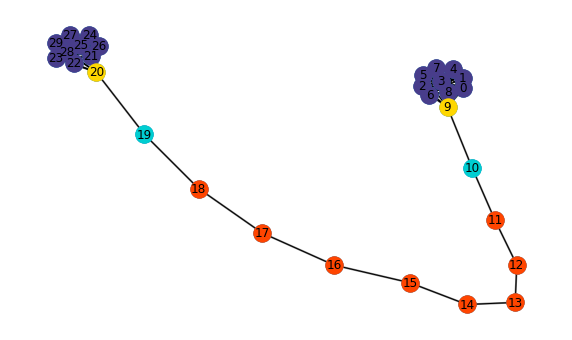

In [ ]:
embedding = model.layer1.weight.T
num_coms = 4
clusters = KMeans(n_clusters=num_coms).fit_predict(embedding.detach().numpy())
communities = []
for i in range(num_coms):
  communities.append(set())
for i in range(len(clusters)):
  communities[clusters[i]].add(i)

G = nx.Graph()
for node in range(maxnode):
  G.add_node(node)

for n1 in edgelists:
  for n2 in edgelists[n1]:
    G.add_edge(n1, n2)

fig = plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, with_labels=True)
colors = ['#483D8B', '#00CED1', '#FF4500', '#FFD700']
for i in range(num_coms):
  nx.draw_networkx_nodes(G, pos, node_size=300, nodelist=list(communities[i]), node_color=colors[i])
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)
plt.axis("off")
plt.show()